# Mock population

In this notebook we generate a mock catalog of GW events

In [1]:
#IMPORT
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz, trapz
import scipy.stats as stats
import time


#PYTHON MODULES
from constants import *
import gwcosmo
import gwpop
import gwutils
import utils
import sensitivity_curves as sc

#PLOTS
import sys
dir_base=sys.path[0]
dir_out=dir_base+"/plots_spectral_sirens/"

#from matplotlib.ticker import ScalarFormatter
#%config InlineBackend.figure_format = 'retina'
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')
fontSz = 15
fontsz = 13
fontssz = 11

new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

---
We load our fiducial universe parameters

In [2]:
from fiducial_universe import *

In [3]:
fmin = 10.
Tobs = 1.
detector = 'O5'
det_Sc = sc.O5
based = 'ground'
snr_th = 8.0

We define the source populations in source masses and redshift.

In this case we choose:
- Refshift: SFR like function
- Primary mass: smooth power-law+peak model
- Secondary mass: uniform in mass ratio

In [4]:
def mock_source_parameters(n_sources,H0,Om0,mMin,mMax,alpha,sig_m1,mu_m1,f_peak,zp,alpha_z,beta):
    zs = np.linspace(0.01,10,1000)
    cdf_z = cumtrapz(gwcosmo.diff_comoving_volume_approx(zs,H0,Om0)*gwpop.rate_z(zs,zp,alpha_z,beta)/(1+zs),zs,initial=0)
    cdf_z /= cdf_z[-1]
    masses = np.linspace(tmp_min,tmp_max,1000)
    cdf_m1 = cumtrapz(gwpop.powerlaw_peak(masses,mMin,mMax,alpha,sig_m1,mu_m1,f_peak),masses,initial=0)
    cdf_m1 /= cdf_m1[-1]

    z_mock = utils.inverse_transf_sampling(cdf_z,zs,n_sources)
    m1_mock = utils.inverse_transf_sampling(cdf_m1,masses,n_sources)
    q_mock = np.random.uniform(0,1,n_sources)
    m2_mock = m1_mock * q_mock
    dL_mock = gwcosmo.dL_approx(z_mock,H0,Om0)
    m1z_mock = (1 + z_mock) * m1_mock
    m2z_mock = (1 + z_mock) * m2_mock
    return m1z_mock, m2z_mock, dL_mock

When computing the mock detections we follow the recipe of https://arxiv.org/pdf/1911.05882.pdf to estimate the observed posteriors

In [5]:
def mock_population(n_sources,n_detections,n_samples,H0,Om0,mMin,mMax,alpha,sig_m1,mu_m1,f_peak,zp,alpha_z,beta,snr_th,fmin,Tobs,detector,*args):
    #n_sources : number of sources to run code
    #n_samples : number of posterior samples per detection
    
    #Mock source paramters
    ww = np.linspace(0.0,1.0,1000)
    cdf_ww = 1.0-gwutils.pw_hl(ww)
    m1z_mock_pop, m2z_mock_pop, dL_mock_pop = mock_source_parameters(n_sources,H0,Om0,mMin,mMax,alpha,sig_m1,mu_m1,f_peak,zp,alpha_z,beta)
    
    #SNR calcultion: optimal SNR -> true SNR -> observed SNR
    snr_opt_mock_pop = gwutils.vsnr(m1z_mock_pop,m2z_mock_pop,dL_mock_pop,fmin,Tobs,det_Sc,based)
    w_mock_pop = utils.inverse_transf_sampling(cdf_ww,ww,n_sources) #random draw
    snr_true_mock_pop = snr_opt_mock_pop*w_mock_pop
    snr_obs_mock_pop = gwutils.observed_snr(snr_true_mock_pop)

    #Detected population
    detected = snr_obs_mock_pop > snr_th
    snr_opt_mock = snr_opt_mock_pop[detected]
    snr_true_mock = snr_true_mock_pop[detected]
    snr_obs_mock = snr_obs_mock_pop[detected]
    m1z_mock = m1z_mock_pop[detected]
    m2z_mock = m2z_mock_pop[detected]
    dL_mock = dL_mock_pop[detected]
    
    snr_opt_mock = snr_opt_mock_pop[detected]
    snr_true_mock = snr_true_mock_pop[detected]
    snr_obs_mock = snr_obs_mock_pop[detected]
    m1z_mock = m1z_mock_pop[detected]
    m2z_mock = m2z_mock_pop[detected]
    dL_mock = dL_mock_pop[detected]
    
    while np.size(snr_opt_mock) < n_detections:    
        m1z_mock_pop, m2z_mock_pop, dL_mock_pop = mock_source_parameters(n_sources,H0,Om0,mMin,mMax,alpha,sig_m1,mu_m1,f_peak,zp,alpha_z,beta)
        snr_opt_mock_pop = gwutils.vsnr(m1z_mock_pop,m2z_mock_pop,dL_mock_pop,fmin,Tobs,det_Sc,based)
        w_mock_pop = utils.inverse_transf_sampling(cdf_ww,ww,n_sources) #random draw
        snr_true_mock_pop = snr_opt_mock_pop*w_mock_pop
        snr_obs_mock_pop = gwutils.observed_snr(snr_true_mock_pop)
    
        detected = snr_obs_mock_pop > snr_th
        snr_opt_mock_add = snr_opt_mock_pop[detected]
        snr_true_mock_add = snr_true_mock_pop[detected]
        snr_obs_mock_add = snr_obs_mock_pop[detected]
        m1z_mock_add = m1z_mock_pop[detected]
        m2z_mock_add = m2z_mock_pop[detected]
        dL_mock_add = dL_mock_pop[detected]
    
        snr_opt_mock = np.append(snr_opt_mock,snr_opt_mock_add)
        snr_true_mock = np.append(snr_true_mock,snr_true_mock_add)
        snr_obs_mock = np.append(snr_obs_mock,snr_obs_mock_add)
        m1z_mock = np.append(m1z_mock,m1z_mock_add)
        m2z_mock = np.append(m2z_mock,m2z_mock_add)
        dL_mock = np.append(dL_mock,dL_mock_add)
    
    snr_opt_mock_det = snr_opt_mock[0:n_detections]
    snr_true_mock_det = snr_true_mock[0:n_detections]
    snr_obs_mock_det = snr_obs_mock[0:n_detections]
    m1z_mock_det = m1z_mock[0:n_detections] 
    m2z_mock_det = m2z_mock[0:n_detections]
    dL_mock_det = dL_mock[0:n_detections]
    
    m1z_mock_samples = np.zeros((n_detections,n_samples))
    m2z_mock_samples = np.zeros((n_detections,n_samples))
    dL_mock_samples = np.zeros((n_detections,n_samples))
    pdraw_mock_samples = np.zeros((n_detections,n_samples))
    for i in range(n_detections):
        m1z_mock_samples[i,:], m2z_mock_samples[i,:], dL_mock_samples[i,:], pdraw_mock_samples[i,:] = gwutils.observed_posteriors(n_samples,
                                                          m1z_mock_det[i],
                                                          m2z_mock_det[i],
                                                          dL_mock_det[i],
                                                          snr_opt_mock_det[i],
                                                          snr_true_mock_det[i],
                                                          snr_obs_mock_det[i],
                                                          snr_th,
                                                          fmin,
                                                          Tobs,
                                                          detector,
                                                          *args)
        
    return m1z_mock_samples, m2z_mock_samples, dL_mock_samples, pdraw_mock_samples

In [6]:
n_detections = 500
n_samples = 20
n_sources = n_detections*10

m1z_mock_samples = np.zeros((n_detections,n_samples))
m2z_mock_samples = np.zeros((n_detections,n_samples))
dL_mock_samples = np.zeros((n_detections,n_samples))
pdraw_mock_samples = np.zeros((n_detections,n_samples))

starttime = time.time()

m1z_mock_samples,m2z_mock_samples,dL_mock_samples,pdraw_mock_samples = mock_population(n_sources,
                                        n_detections,
                                        n_samples,
                                        H0_fid,
                                        Om0_fid,
                                        mmin_fid,
                                        mmax_fid,
                                        alpha_fid,
                                        sig_m1_fid,
                                        mu_m1_fid,
                                        f_peak_fid,
                                        zp_fid,
                                        alpha_z_fid,
                                        beta_fid,
                                        snr_th,
                                        fmin,
                                        Tobs,
                                        det_Sc,
                                        based)

print('Time taken = {} seconds'.format(time.time() - starttime))

Time taken = 477.97517800331116 seconds


Some events incompatible with mmin
Some events incompatible with mmin
Some events incompatible with mmin
Some events incompatible with mmin
Some events incompatible with mmin
Some events incompatible with mmin
Some events incompatible with mmin
Some events incompatible with mmin
Some events incompatible with mmin
Some events incompatible with mmin
Some events incompatible with mmin
Some events incompatible with mmin
Some events incompatible with mmin
Some events incompatible with mmin
Some events incompatible with mmin
Some events incompatible with mmin
Some events incompatible with mmin
Some events incompatible with mmin
Some events incompatible with mmin
Some events incompatible with mmin
Some events incompatible with mmin
Some events incompatible with mmin
Some events incompatible with mmin
Some events incompatible with mmin
Some events incompatible with mmin
Some events incompatible with mmin
Some events incompatible with mmin
Some events incompatible with mmin
Some events incompat

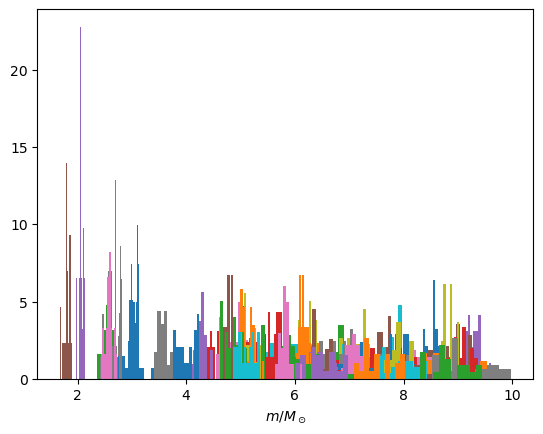

In [7]:
m11, m22, zz = gwcosmo.detector_to_source_frame(m1z_mock_samples,m2z_mock_samples,dL_mock_samples,H0_fid,Om0_fid,zmin=1e-3,zmax=100)

for i in range(n_detections):
    if max(m22[i,:]) < mmin_fid:
        print('Some events incompatible with mmin')
        plt.hist(m22[i,:],density=True)
    if min(m11[i,:]) > mmax_fid:
        print('Some events incompatible with mmax')
        plt.hist(m11[i,:],density=True)
#plt.xlim(0,5) 
plt.xlabel(r'$m/M_\odot$')
plt.show()

In [8]:
np.save('data_mock_catalogues/m1z_'+detector+'_Ndet_%s_Nsamples_%s' % (n_detections,n_samples),m1z_mock_samples)
np.save('data_mock_catalogues/m2z_'+detector+'_Ndet_%s_Nsamples_%s' % (n_detections,n_samples),m2z_mock_samples)
np.save('data_mock_catalogues/dL_'+detector+'_Ndet_%s_Nsamples_%s' % (n_detections,n_samples),dL_mock_samples)
np.save('data_mock_catalogues/pdraw_'+detector+'_Ndet_%s_Nsamples_%s' % (n_detections,n_samples),pdraw_mock_samples)

---
# Other cases

Below there are functions to compute mock popul with/out selection effects and with/out measurement errors

All detected, no errors

In [19]:
def mock_population_perfect(n_sources,n_detections,n_samples,H0,Om0,mMin,mMax,alpha,sig_m1,mu_m1,f_peak,zp,alpha_z,beta,snr_th,fmin,Tobs,detector,*args):
    #n_sources : number of sources to run code
    #n_samples : number of posterior samples per detection
    
    #Mock source paramters
    ww = np.linspace(0.0,1.0,1000)
    cdf_ww = 1.0-gw.pw_hl(ww)
    m1z_mock_pop, m2z_mock_pop, dL_mock_pop = mock_source_parameters(n_sources,H0,Om0,mMin,mMax,alpha,sig_m1,mu_m1,f_peak,zp,alpha_z,beta)
    
    #SNR calcultion: optimal SNR -> true SNR -> observed SNR
    snr_opt_mock_pop = gw.vsnr(m1z_mock_pop,m2z_mock_pop,dL_mock_pop,fmin,Tobs,det_Sc,based)
    w_mock_pop = pop.inverse_transf_sampling(cdf_ww,ww,n_sources) #random draw
    snr_true_mock_pop = snr_opt_mock_pop*w_mock_pop
    snr_obs_mock_pop = observed_snr(snr_true_mock_pop)

    #Detected population
    detected = snr_obs_mock_pop> 0.
    snr_opt_mock = snr_opt_mock_pop[detected]
    snr_true_mock = snr_true_mock_pop[detected]
    snr_obs_mock = snr_obs_mock_pop[detected]
    m1z_mock = m1z_mock_pop[detected]
    m2z_mock = m2z_mock_pop[detected]
    dL_mock = dL_mock_pop[detected]
    
    m1z_mock_samples = np.zeros((n_detections,n_samples))
    m2z_mock_samples = np.zeros((n_detections,n_samples))
    dL_mock_samples = np.zeros((n_detections,n_samples))
    pdraw_mock_samples = np.zeros((n_detections,n_samples))
    for i in range(n_detections):
        m1z_mock_samples[i,:], m2z_mock_samples[i,:], dL_mock_samples[i,:], pdraw_mock_samples[i,:] = m1z_mock[i], m2z_mock[i], dL_mock[i], 1.
        
    return m1z_mock_samples, m2z_mock_samples, dL_mock_samples, pdraw_mock_samples

In [22]:
n_detections = 10000
n_samples = 1
n_sources = n_detections

m1z_mock_samples_O5 = np.zeros((n_detections,n_samples))
m2z_mock_samples_O5 = np.zeros((n_detections,n_samples))
dL_mock_samples_O5 = np.zeros((n_detections,n_samples))
pdraw_mock_samples_O5 = np.zeros((n_detections,n_samples))

starttime = time.time()

m1z_mock_samples_O5,m2z_mock_samples_O5,dL_mock_samples_O5,pdraw_mock_samples_O5 = mock_population_perfect(n_sources,
                                        n_detections,
                                        n_samples,
                                        H0_fid,
                                        Om0_fid,
                                        mmin_fid,
                                        mmax_fid,
                                        alpha_fid,
                                        sig_m1_fid,
                                        mu_m1_fid,
                                        f_peak_fid,
                                        zp_fid,
                                        alpha_z_fid,
                                        beta_fid,
                                        snr_th,
                                        fmin,
                                        Tobs,
                                        det_Sc,
                                        based)

print('Time taken = {} seconds'.format(time.time() - starttime))

Time taken = 16.287160873413086 seconds


In [23]:
np.save('data_mock_catalogues/m1z_gamma1_%s_gamma2_%s_O5_Ndet_%s_Nsamples_%s_perfect' % (gamma1_fid,gamma2_fid,n_detections,n_samples),m1z_mock_samples_O5)
np.save('data_mock_catalogues/m2z_gamma1_%s_gamma2_%s_O5_Ndet_%s_Nsamples_%s_perfect' % (gamma1_fid,gamma2_fid,n_detections,n_samples),m2z_mock_samples_O5)
np.save('data_mock_catalogues/dL_gamma1_%s_gamma2_%s_O5_Ndet_%s_Nsamples_%s_perfect' % (gamma1_fid,gamma2_fid,n_detections,n_samples),dL_mock_samples_O5)
np.save('data_mock_catalogues/pdraw_gamma1_%s_gamma2_%s_O5_Ndet_%s_Nsamples_%s_perfect' % (gamma1_fid,gamma2_fid,n_detections,n_samples),pdraw_mock_samples_O5)

---

All detected, Gaussian errors

In [24]:
"""Posteriors"""
def error_pe_detector(detector):
    sigma_Mc, sigma_eta, sigma_w = [3.0e-2,5.0e-3,5.0e-2]
    if any(detector == x for x in np.array([sc.O1,sc.O2,sc.O3,sc.LIGOeh])):
        sigma_Mc, sigma_eta, sigma_w = [8.0e-2,2.2e-2,2.1e-1]
    elif any(detector == x for x in np.array([sc.O4,sc.aLIGO])):
        sigma_Mc, sigma_eta, sigma_w = [8.0e-2,1.0e-2,8.0e-2]
    elif any(detector == x for x in np.array([sc.O5,sc.Aplus])):
        sigma_Mc, sigma_eta, sigma_w = [3.0e-3,5.0e-4,5.0e-3] #HERE [3.0e-2,5.0e-3,5.0e-2]
    elif detector == sc.voyager:
        sigma_Mc, sigma_eta, sigma_w = [1.0e-2,2.0e-3,5.0e-2]
    elif detector == sc.LISA:
        sigma_Mc, sigma_eta, sigma_w = [3.0e-2,5.0e-3,5.0e-2]
    elif detector == sc.ET:
        sigma_Mc, sigma_eta, sigma_w = [5.0e-3,7.0e-4,2.0e-2]
    elif detector == sc.CE:
        sigma_Mc, sigma_eta, sigma_w = [5.0e-3,7.0e-4,2.0e-2]
    return sigma_Mc,sigma_eta,sigma_w

"""Observed posteriors"""
def observed_posteriors_fixed_error(n_samples,m1z,m2z,dL,snr_opt,snr_true,snr_obs,snr_th,fmin,Tobs,detector,*args):
    #clevel = 1.65 #90% CL
    sigma_Mc,sigma_eta,sigma_w = error_pe_detector(detector)
    
    Mz = gw.mchirp(m1z,m2z) #source frame masses
    etas = gw.eta(m1z,m2z)
    #Mz
    logMz_obs = np.random.normal(loc=np.log(Mz),scale=sigma_Mc,size=n_samples)
    Mz_obs = np.exp(logMz_obs)
    #eta
    lower_etas, upper_etas = 0.0, 0.25
    mu_etas, sigma_etas = etas, sigma_eta
    eta_obs = stats.truncnorm.rvs((lower_etas - mu_etas) / sigma_etas, (upper_etas - mu_etas) / sigma_etas, loc=mu_etas, scale=sigma_etas,size=n_samples)
    #w
    w = snr_true/snr_opt
    lower_ws, upper_ws = 0.0, 1.0
    mu_ws, sigma_ws = w, sigma_w
    w_obs = stats.truncnorm.rvs((lower_ws - mu_ws) / sigma_ws, (upper_ws - mu_ws) / sigma_ws, loc=mu_ws, scale=sigma_ws, size=n_samples)
    
    M_obs = Mz_obs / eta_obs**(3./5.)
    m1z_obs = (M_obs + np.sqrt(M_obs**2 - 4.* eta_obs * M_obs**2))/2.
    m2z_obs = (M_obs - np.sqrt(M_obs**2 - 4.* eta_obs * M_obs**2))/2.
    
    snr_opt_1Mpc = gw.vsnr(m1z_obs,m2z_obs,dL,fmin,Tobs,detector,*args)
    dL_obs = dL*snr_opt_1Mpc * w_obs / snr_obs #Mpc
    
    pdraw = np.abs(w_obs * snr_opt_1Mpc * (m1z_obs - m2z_obs) * np.power(gw.eta(m1z_obs,m2z_obs),3./5)/np.power(m1z_obs + m2z_obs,2) / np.power(dL_obs,2))

    return m1z_obs, m2z_obs, dL_obs, pdraw

vobserved_posteriors_fixed_error = np.vectorize(observed_posteriors_fixed_error)

In [25]:
def mock_population_fixed_error(n_sources,n_detections,n_samples,H0,Om0,mMin,mMax,alpha,sig_m1,mu_m1,f_peak,zp,alpha_z,beta,snr_th,fmin,Tobs,detector,*args):
    #n_sources : number of sources to run code
    #n_samples : number of posterior samples per detection
    
    #Mock source paramters
    ww = np.linspace(0.0,1.0,1000)
    cdf_ww = 1.0-gw.pw_hl(ww)
    m1z_mock_pop, m2z_mock_pop, dL_mock_pop = mock_source_parameters(n_sources,H0,Om0,mMin,mMax,alpha,sig_m1,mu_m1,f_peak,zp,alpha_z,beta)
    
    #SNR calcultion: optimal SNR -> true SNR -> observed SNR
    snr_opt_mock_pop = gw.vsnr(m1z_mock_pop,m2z_mock_pop,dL_mock_pop,fmin,Tobs,det_Sc,based)
    w_mock_pop = pop.inverse_transf_sampling(cdf_ww,ww,n_sources) #random draw
    snr_true_mock_pop = snr_opt_mock_pop*w_mock_pop
    snr_obs_mock_pop = observed_snr(snr_true_mock_pop)

    #Detected population
    detected = snr_obs_mock_pop> 0.
    snr_opt_mock = snr_opt_mock_pop[detected]
    snr_true_mock = snr_true_mock_pop[detected]
    snr_obs_mock = snr_obs_mock_pop[detected]
    m1z_mock = m1z_mock_pop[detected]
    m2z_mock = m2z_mock_pop[detected]
    dL_mock = dL_mock_pop[detected]
    
    m1z_mock_samples = np.zeros((n_detections,n_samples))
    m2z_mock_samples = np.zeros((n_detections,n_samples))
    dL_mock_samples = np.zeros((n_detections,n_samples))
    pdraw_mock_samples = np.zeros((n_detections,n_samples))
    for i in range(n_detections):
        m1z_mock_samples[i,:], m2z_mock_samples[i,:], dL_mock_samples[i,:], pdraw_mock_samples[i,:] = observed_posteriors_fixed_error(n_samples,
                                                          m1z_mock_det[i],
                                                          m2z_mock_det[i],
                                                          dL_mock_det[i],
                                                          snr_opt_mock_det[i],
                                                          snr_true_mock_det[i],
                                                          snr_obs_mock_det[i],
                                                          snr_th,
                                                          fmin,
                                                          Tobs,
                                                          detector,
                                                          *args) 
    return m1z_mock_samples, m2z_mock_samples, dL_mock_samples, pdraw_mock_samples

In [28]:
n_detections = 1000
n_samples = 100
n_sources = n_detections

m1z_mock_samples_O5 = np.zeros((n_detections,n_samples))
m2z_mock_samples_O5 = np.zeros((n_detections,n_samples))
dL_mock_samples_O5 = np.zeros((n_detections,n_samples))
pdraw_mock_samples_O5 = np.zeros((n_detections,n_samples))

starttime = time.time()

m1z_mock_samples_O5,m2z_mock_samples_O5,dL_mock_samples_O5,pdraw_mock_samples_O5 = mock_population_perfect(n_sources,
                                        n_detections,
                                        n_samples,
                                        H0_fid,
                                        Om0_fid,
                                        mmin_fid,
                                        mmax_fid,
                                        alpha_fid,
                                        sig_m1_fid,
                                        mu_m1_fid,
                                        f_peak_fid,
                                        zp_fid,
                                        alpha_z_fid,
                                        beta_fid,
                                        snr_th,
                                        fmin,
                                        Tobs,
                                        det_Sc,
                                        based)

print('Time taken = {} seconds'.format(time.time() - starttime))

Time taken = 1.6230309009552002 seconds


In [29]:
np.save('data_mock_catalogues/m1z_gamma1_%s_gamma2_%s_O5_Ndet_%s_Nsamples_%s_fixed_error' % (gamma1_fid,gamma2_fid,n_detections,n_samples),m1z_mock_samples_O5)
np.save('data_mock_catalogues/m2z_gamma1_%s_gamma2_%s_O5_Ndet_%s_Nsamples_%s_fixed_error' % (gamma1_fid,gamma2_fid,n_detections,n_samples),m2z_mock_samples_O5)
np.save('data_mock_catalogues/dL_gamma1_%s_gamma2_%s_O5_Ndet_%s_Nsamples_%s_fixed_error' % (gamma1_fid,gamma2_fid,n_detections,n_samples),dL_mock_samples_O5)
np.save('data_mock_catalogues/pdraw_gamma1_%s_gamma2_%s_O5_Ndet_%s_Nsamples_%s_fixed_error' % (gamma1_fid,gamma2_fid,n_detections,n_samples),pdraw_mock_samples_O5)

---

Selection, no errors

In [30]:
def mock_population_no_errors(n_sources,n_detections,n_samples,H0,Om0,mMin,mMax,alpha,sig_m1,mu_m1,f_peak,zp,alpha_z,beta,snr_th,fmin,Tobs,detector,*args):
    #n_sources : number of sources to run code
    #n_samples : number of posterior samples per detection
    
    #Mock source paramters
    ww = np.linspace(0.0,1.0,1000)
    cdf_ww = 1.0-gw.pw_hl(ww)
    m1z_mock_pop, m2z_mock_pop, dL_mock_pop = mock_source_parameters(n_sources,H0,Om0,mMin,mMax,alpha,sig_m1,mu_m1,f_peak,zp,alpha_z,beta)
    
    #SNR calcultion: optimal SNR -> true SNR -> observed SNR
    snr_opt_mock_pop = gw.vsnr(m1z_mock_pop,m2z_mock_pop,dL_mock_pop,fmin,Tobs,det_Sc,based)
    w_mock_pop = pop.inverse_transf_sampling(cdf_ww,ww,n_sources) #random draw
    snr_true_mock_pop = snr_opt_mock_pop*w_mock_pop
    snr_obs_mock_pop = observed_snr(snr_true_mock_pop)

    #Detected population
    detected = snr_obs_mock_pop > snr_th
    snr_opt_mock = snr_opt_mock_pop[detected]
    snr_true_mock = snr_true_mock_pop[detected]
    snr_obs_mock = snr_obs_mock_pop[detected]
    m1z_mock = m1z_mock_pop[detected]
    m2z_mock = m2z_mock_pop[detected]
    dL_mock = dL_mock_pop[detected]
    
    snr_opt_mock = snr_opt_mock_pop[detected]
    snr_true_mock = snr_true_mock_pop[detected]
    snr_obs_mock = snr_obs_mock_pop[detected]
    m1z_mock = m1z_mock_pop[detected]
    m2z_mock = m2z_mock_pop[detected]
    dL_mock = dL_mock_pop[detected]
    
    while np.size(snr_opt_mock) < n_detections:    
        m1z_mock_pop, m2z_mock_pop, dL_mock_pop = mock_source_parameters(n_sources,H0,Om0,mMin,mMax,alpha,sig_m1,mu_m1,f_peak,zp,alpha_z,beta)
        snr_opt_mock_pop = gw.vsnr(m1z_mock_pop,m2z_mock_pop,dL_mock_pop,fmin,Tobs,det_Sc,based)
        w_mock_pop = pop.inverse_transf_sampling(cdf_ww,ww,n_sources) #random draw
        snr_true_mock_pop = snr_opt_mock_pop*w_mock_pop
        snr_obs_mock_pop = observed_snr(snr_true_mock_pop)
    
        detected = snr_obs_mock_pop > snr_th
        snr_opt_mock_add = snr_opt_mock_pop[detected]
        snr_true_mock_add = snr_true_mock_pop[detected]
        snr_obs_mock_add = snr_obs_mock_pop[detected]
        m1z_mock_add = m1z_mock_pop[detected]
        m2z_mock_add = m2z_mock_pop[detected]
        dL_mock_add = dL_mock_pop[detected]
    
        snr_opt_mock = np.append(snr_opt_mock,snr_opt_mock_add)
        snr_true_mock = np.append(snr_true_mock,snr_true_mock_add)
        snr_obs_mock = np.append(snr_obs_mock,snr_obs_mock_add)
        m1z_mock = np.append(m1z_mock,m1z_mock_add)
        m2z_mock = np.append(m2z_mock,m2z_mock_add)
        dL_mock = np.append(dL_mock,dL_mock_add)
    
    snr_opt_mock_det = snr_opt_mock[0:n_detections]
    snr_true_mock_det = snr_true_mock[0:n_detections]
    snr_obs_mock_det = snr_obs_mock[0:n_detections]
    m1z_mock_det = m1z_mock[0:n_detections] 
    m2z_mock_det = m2z_mock[0:n_detections]
    dL_mock_det = dL_mock[0:n_detections]
    
    m1z_mock_samples = np.zeros((n_detections,n_samples))
    m2z_mock_samples = np.zeros((n_detections,n_samples))
    dL_mock_samples = np.zeros((n_detections,n_samples))
    pdraw_mock_samples = np.zeros((n_detections,n_samples))
    for i in range(n_detections):
        m1z_mock_samples[i,:], m2z_mock_samples[i,:], dL_mock_samples[i,:], pdraw_mock_samples[i,:] = m1z_mock_det[i], m2z_mock_det[i], dL_mock_det[i], 1.
        
    return m1z_mock_samples, m2z_mock_samples, dL_mock_samples, pdraw_mock_samples

In [35]:
n_detections = 500
n_samples = 1
n_sources = n_detections
snr_th = 8.

m1z_mock_samples_O5 = np.zeros((n_detections,n_samples))
m2z_mock_samples_O5 = np.zeros((n_detections,n_samples))
dL_mock_samples_O5 = np.zeros((n_detections,n_samples))
pdraw_mock_samples_O5 = np.zeros((n_detections,n_samples))

starttime = time.time()

m1z_mock_samples_O5,m2z_mock_samples_O5,dL_mock_samples_O5,pdraw_mock_samples_O5 = mock_population_no_errors(n_sources,
                                        n_detections,
                                        n_samples,
                                        H0_fid,
                                        Om0_fid,
                                        mmin_fid,
                                        mmax_fid,
                                        alpha_fid,
                                        sig_m1_fid,
                                        mu_m1_fid,
                                        f_peak_fid,
                                        zp_fid,
                                        alpha_z_fid,
                                        beta_fid,
                                        snr_th,
                                        fmin,
                                        Tobs,
                                        det_Sc,
                                        based)

print('Time taken = {} seconds'.format(time.time() - starttime))

Time taken = 11.596833944320679 seconds


In [36]:
np.save('data_mock_catalogues/m1z_gamma1_%s_gamma2_%s_O5_Ndet_%s_Nsamples_%s_no_errors' % (gamma1_fid,gamma2_fid,n_detections,n_samples),m1z_mock_samples_O5)
np.save('data_mock_catalogues/m2z_gamma1_%s_gamma2_%s_O5_Ndet_%s_Nsamples_%s_no_errors' % (gamma1_fid,gamma2_fid,n_detections,n_samples),m2z_mock_samples_O5)
np.save('data_mock_catalogues/dL_gamma1_%s_gamma2_%s_O5_Ndet_%s_Nsamples_%s_no_errors' % (gamma1_fid,gamma2_fid,n_detections,n_samples),dL_mock_samples_O5)
np.save('data_mock_catalogues/pdraw_gamma1_%s_gamma2_%s_O5_Ndet_%s_Nsamples_%s_no_errors' % (gamma1_fid,gamma2_fid,n_detections,n_samples),pdraw_mock_samples_O5)